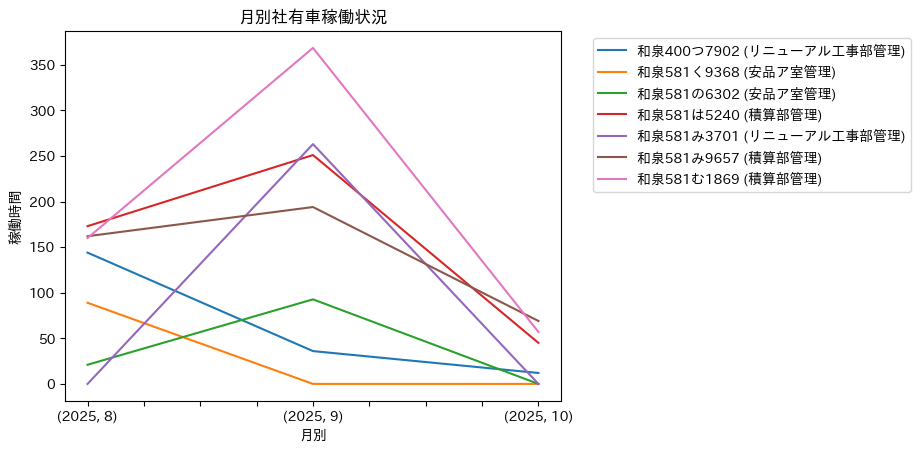

In [35]:
import pandas as pd
from datetime import datetime,date
from glob import glob
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 各社有車の稼働時間のまとめ

### 目的
## 社員が予約した内容から社有車の稼働時間を算出するための元データとしてまとめる
## 一つのデータフレームにまとめ、重複したデータは削除する。
## 生のデータフレームを返す(return)

def load_and_combine_reservations():
    """
    指定されたパターンの予約リストCSVファイルを全て読み込み、
    一つのデータフレームに結合して返す。
    結合の過程で重複した行は削除される。
    """

    yoyaku_files = glob('ご予約リスト_*.csv')
    
    df_LIST = []
    df_raw = pd.DataFrame()

    for file in yoyaku_files:
        df_single_file = pd.read_csv(file,encoding = 'shift_jis')
        df_LIST.append(df_single_file)
    df_concat = pd.concat(df_LIST,ignore_index=True)
    df_concat = df_concat.drop_duplicates()
    return df_concat

def yoyaku_list_surgery(df):
    """
    予約データフレームを受け取り、表やグラフ作成にあたって一部整形する。
    """
    df[['予約日','時間範囲_str']]= df['予約日時'].str.split(' ',expand=True)
    df[['開始時刻','終了時刻']]=df['時間範囲_str'].str.split('\r\n~',expand=True)
    df['開始時刻']=pd.to_datetime(df['開始時刻'],format='%H：%M')
    df['終了時刻']=pd.to_datetime(df['終了時刻'],format='%H：%M')
    df['実稼働時間_timedelta']=df['終了時刻']-df['開始時刻']
    total_seconds = df['実稼働時間_timedelta'].dt.total_seconds()
    df['実稼働時間_hour']=total_seconds/3600
    df['予約日']=pd.to_datetime(df['予約日'])
    df['年度']=df['予約日'].dt.year
    df['月度']=df['予約日'].dt.month
    df['曜日']=df['予約日'].dt.day_name()
    
    return df

def make_report(df):
    report_pivot=pd.pivot_table(df,
                                index=['年度','月度'],
                                columns='予約内容',
                                values='実稼働時間_hour',
                                aggfunc='sum',
                                fill_value=0)
    df.groupby(['年度','月度'])['予約内容'].sum()
    return report_pivot

def visualize(df):
    df.plot()
    # plt.figure(figsize=(8.0,12.0))
    # plt.plot(df['月度'],df['実稼働時間_hour'],'o-')
    plt.title('月別社有車稼働状況')
    plt.xlabel('月別')
    plt.ylabel('稼働時間')
    plt.legend(bbox_to_anchor=(1.05,1))
    plt.show






df = load_and_combine_reservations()
row_data = yoyaku_list_surgery(df)
report = make_report(row_data)
viz = visualize(report)
viz 







